# Sphering transform on text embeddings

This is a demonstration, just to get the idea across. We used a VERY simple document representation: the average word2vec embedding of the words of the document. This is sufficient to detect the difference between the two corpora that we used, but probably not much else. 

All the data used in this example (preprocessed and ready to go) can be found [in this zip file](https://drive.google.com/drive/folders/1sXtDqNF-D0mypORzfevir_eH9FdG2668).

In [1]:
from typing import Dict
from numpy.linalg import norm
import pandas as pd
import numpy as np
import polars as pl
import re
import csv
import matplotlib.pyplot as plt
import seaborn as sns

# our modules
from w2v_text_embed import W2VEmbed
from sphering_transform import SpheringTransform
from distribution_diff import DistCalculator

In [2]:
rng = np.random.default_rng(2023)

## Read in the word2vec embedding

In [3]:
# use Polars to read word2vec TSV
d = pl.read_csv(
    'data/word2vec/word2vec.tsv.gz', 
    separator='\t',
    comment_char=None,
    quote_char=None,
    )

d

word,v00000,v00001,v00002,v00003,v00004,v00005,v00006,v00007,v00008,v00009,v00010,v00011,v00012,v00013,v00014,v00015,v00016,v00017,v00018,v00019,v00020,v00021,v00022,v00023,v00024,v00025,v00026,v00027,v00028,v00029,v00030,v00031,v00032,v00033,v00034,v00035,…,v00263,v00264,v00265,v00266,v00267,v00268,v00269,v00270,v00271,v00272,v00273,v00274,v00275,v00276,v00277,v00278,v00279,v00280,v00281,v00282,v00283,v00284,v00285,v00286,v00287,v00288,v00289,v00290,v00291,v00292,v00293,v00294,v00295,v00296,v00297,v00298,v00299
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""</s>""",0.001129,-0.000896,0.000319,0.001534,0.001106,-0.001404,-0.000031,-0.00042,-0.000576,0.001076,-0.001022,-0.000618,-0.000755,0.001404,-0.00164,-0.000633,0.001633,-0.001007,-0.001266,0.000652,-0.000416,-0.001076,0.001526,-0.000275,0.00014,0.001572,0.001358,-0.000832,-0.001404,0.001579,0.000254,-0.000732,-0.000105,-0.001167,0.001579,0.000656,…,0.000591,-0.001465,0.000965,-0.001282,0.001602,0.001091,-0.001312,0.001091,-0.000511,0.000345,0.001045,-0.000207,0.000904,0.000668,0.001106,-0.000874,-0.000376,-0.000257,-0.000092,0.001434,-0.001183,-0.000087,0.001328,-0.000158,0.001289,-0.000984,-0.000549,-0.001549,0.001373,-0.000061,-0.000824,0.001328,0.00116,0.000568,-0.001564,-0.000123,-0.000086
"""in""",0.0703125,0.086914,0.087891,0.0625,0.069336,-0.108887,-0.081543,-0.154297,0.020752,0.131836,-0.11377,-0.037354,0.069336,0.078125,-0.103027,-0.097656,0.044189,0.102539,-0.060791,-0.036133,-0.04541,0.047363,-0.120605,-0.063965,0.002258,0.037109,-0.002914,0.117676,0.061768,0.063965,0.081055,-0.068848,-0.021362,0.055176,-0.085449,0.068848,…,0.170898,0.173828,0.055664,0.091309,-0.037354,0.049805,-0.039307,0.044189,0.0625,0.048584,-0.053223,0.048828,-0.130859,-0.028931,-0.036133,-0.060791,-0.057373,0.123047,-0.08252,-0.011902,0.125,0.001358,0.063965,-0.106445,-0.143555,-0.042236,0.024048,-0.168945,-0.088867,-0.080566,0.064941,0.061279,-0.047363,-0.058838,-0.047607,0.014465,-0.0625
"""for""",-0.01178,-0.047363,0.044678,0.063477,-0.018188,-0.063965,-0.001312,-0.072266,0.064453,0.086426,-0.169922,-0.039795,0.071289,-0.025879,0.018188,0.136719,0.144531,-0.033691,-0.097656,-0.120117,-0.07959,0.0625,-0.066895,0.074219,0.022705,0.033447,-0.180664,0.052002,0.013855,0.092773,0.00351,-0.009094,-0.097168,0.067871,-0.008789,0.044189,…,0.046387,0.047852,0.098145,-0.040283,0.094238,-0.034668,-0.042236,0.0703125,-0.013672,0.106445,0.016479,0.131836,-0.001694,-0.008484,-0.142578,-0.046631,-0.109863,0.082031,-0.041016,-0.018921,0.087891,-0.002808,0.238281,-0.047119,-0.022949,0.040771,0.029297,-0.022583,0.003723,-0.08252,0.081543,0.007935,0.000477,0.018433,0.071289,-0.034912,0.02417
"""that""",-0.015747,-0.02832,0.083496,0.050293,-0.110352,0.031738,-0.014221,-0.089844,0.117676,0.118164,-0.071777,-0.077148,-0.068848,0.077148,-0.138672,0.0065,0.010986,-0.015137,-0.000961,-0.030273,-0.000158,0.03833,-0.02417,-0.045898,0.094727,-0.055176,-0.064941,0.006104,0.000854,0.062012,-0.054443,0.014099,0.022217,-0.044922,0.111328,-0.038574,…,0.106445,-0.039795,0.116211,-0.009705,-0.0354,-0.06543,0.058838,0.162109,0.05127,0.15918,0.095215,0.076172,-0.091797,0.025146,-0.078613,0.089355,-0.058594,-0.040039,0.045898,0.031006,0.0390625,0.035645,-0.105957,-0.037109,-0.161133,0.021362,0.001221,-0.011292,-0.015625,-0.033447,-0.02063,-0.019409,0.063965,0.020142,0.006866,0.061035,-0.148438
"""is""",0.00705,-0.073242,0.171875,0.022583,-0.132812,0.198242,0.112793,-0.10791,0.071777,0.020874,-0.123047,-0.059082,0.101074,0.010742,0.143555,0.259766,-0.036377,0.185547,-0.078613,-0.022705,-0.120605,0.177734,0.049561,0.017212,0.07959,-0.045654,-0.188477,0.189453,-0.023193,0.062988,0.097656,-0.019043,-0.079102,0.152344,0.173828,0.1015625,…,0.072266,0.04126,0.425781,-0.103027,-0.1601

### Create the embedder

This will take a while.

In [4]:
emb = W2VEmbed(d)
del d

In [5]:
# quick demo
emb.transform_str("hello there, boys")

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.005127,0.095744,0.021718,0.072266,-0.135152,-0.106222,-0.067057,-0.098796,0.053019,0.281576,...,-0.050659,0.12439,-0.056559,-0.134359,0.029093,-0.018555,-0.022371,-0.209635,-0.000366,-0.01888


## Read in the text corpora

IMDB and SMS Spam

In [6]:
imdb_frame = pd.read_csv(
    "data/IMDB/IMDB.tsv.gz",
    sep='\t',
    quoting=csv.QUOTE_NONE,
    quotechar=None,
    comment=None,
)

imdb_frame

,fname,text,what
0,train/pos/4715_9.txt,"""For a movie that gets no respect there sure a...",train/pos
1,train/pos/12390_8.txt,"""Bizarre horror movie filled with famous faces...",train/pos
2,train/pos/8329_7.txt,"A solid, if unremarkable film. Matthau, as Ein...",train/pos
3,train/pos/9063_8.txt,"""It's a strange feeling to sit alone in a thea...",train/pos
4,train/pos/3092_10.txt,"You probably all already know this by now, but...",train/pos
...,...,...,...
49995,test/neg/11513_1.txt,With actors like Depardieu and Richard it is r...,test/neg
49996,test/neg/5409_1.txt,"""If you like to get a couple of fleeting glimp...",test/neg
49997,test/neg/11187_1.txt,When something can be anything you want it to ...,test/neg
49998,test/neg/9359_3.txt,"""I had heard good things about """"States of Gra...",test/neg


In [7]:
spam_texts = pd.read_csv(
    "data/smsspamcollection/SMSSpamCollection.tsv.gz", 
    sep="\t",
    quotechar=None,
    quoting=csv.QUOTE_NONE,
    comment=None,
    )

spam_texts

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...
5570,ham,Will ü b going to esplanade fr home?
5571,ham,"Pity, * was in mood for that. So...any other s..."
5572,ham,The guy did some bitching but I acted like i'd...


## First task - distinguish IMDB reviews from spam texts

We'll use a sample of positive IMDB reviews as the reference distribution, and compare it to

* another sample of positive IMDB reviews
* a sample of negative IMDB reviews
* a sample of SMS spam

In [8]:
# first, get the embeddings of all the sample sets

train_frame = emb.transform(imdb_frame.loc[imdb_frame["what"] == "train/pos", "text"])
test_frame_pos = emb.transform(imdb_frame.loc[imdb_frame["what"] == "test/pos", "text"])
test_frame_neg = emb.transform(imdb_frame.loc[imdb_frame["what"] == "test/neg", "text"])
spam_frame = emb.transform(spam_texts["text"])

In [9]:
# now fit the sphering transform on the reference set
st = SpheringTransform()
st.fit(train_frame)

In [10]:
# sphere-transform all the data sets
xformed_train = st.transform(train_frame)
xformed_test_pos = st.transform(test_frame_pos)
xformed_test_neg = st.transform(test_frame_neg)
xformed_spam_frame = st.transform(spam_frame)

We will compare the different text embedding distributions (in transform space) by comparing the distributions of norms of each transformed embedding.

In [11]:
# get the norms

imdb_train_pos = norm(xformed_train, axis=1)  # the reference distribution
imdb_test_neg = norm(xformed_test_neg, axis=1)
imdb_test_pos = norm(xformed_test_pos, axis=1)
sms_text = norm(xformed_spam_frame, axis=1)

### Compare visually

We can distinguish the SMS messages from the IMDB reviews. This document representation is not sensitive enough to distinguish positive reviews from negative ones.

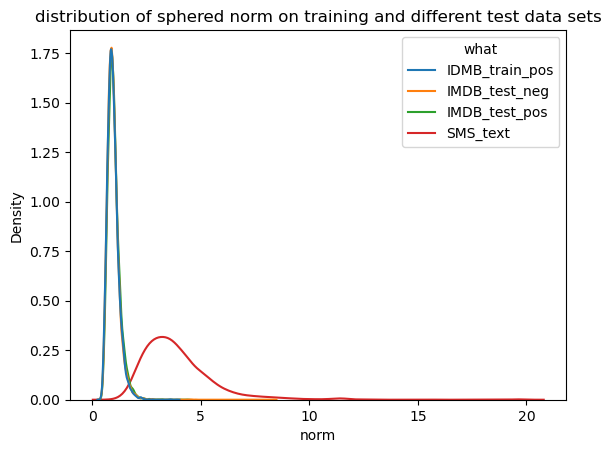

In [12]:
comparison_frame = pd.concat([
    pd.DataFrame({
        'norm': imdb_train_pos,
        'what': "IDMB_train_pos",
    }),
    pd.DataFrame({
        'norm': imdb_test_neg,
        'what': "IMDB_test_neg",
    }),
    pd.DataFrame({
        'norm': imdb_test_pos,
        'what': "IMDB_test_pos",
    }),
    pd.DataFrame({
        'norm': sms_text,
        'what': "SMS_text",
    }),
])

sns.kdeplot(
    data=comparison_frame,
    x="norm",
    hue="what",
    common_norm=False,
)
plt.title("distribution of sphered norm on training and different test data sets")
plt.show()

We can also measure the difference quantitatively using the Population Stability Index (or your preferred distribution divergence metric).

This PSI calculator uses decile binning. A common rule of thumb:

* PSI < 0.1: distributions are similar
* PSI between 0.1 and 0.25: distributions are somewhat different
* PSI > 0.25: distributions are very different

In [13]:
psiCalc = DistCalculator(imdb_train_pos)

{
    'psi test pos': psiCalc.PSI(imdb_test_pos),
    'psi test neg': psiCalc.PSI(imdb_test_neg),
    'psi sms text': psiCalc.PSI(sms_text)
}

{'psi test pos': 0.0120601197683604,
 'psi test neg': 0.0007532764568599546,
 'psi sms text': 7.889785670522413}

### Measuring the embeddings in the original space

For comparison, let's compare the embedding norms in the original space.

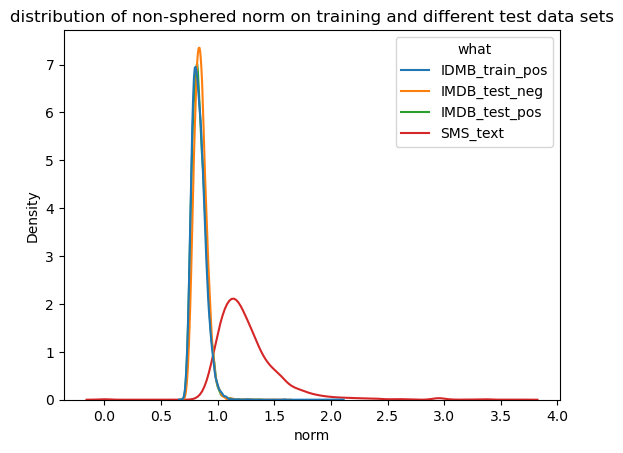

In [14]:
imdb_train_pos = norm(train_frame, axis=1)
imdb_test_neg = norm(test_frame_neg, axis=1)
imdb_test_pos = norm(test_frame_pos, axis=1)
sms_text = norm(spam_frame, axis=1)

comparison_frame = pd.concat([
    pd.DataFrame({
        'norm': imdb_train_pos,
        'what': "IDMB_train_pos",
    }),
    pd.DataFrame({
        'norm': imdb_test_neg,
        'what': "IMDB_test_neg",
    }),
    pd.DataFrame({
        'norm': imdb_test_pos,
        'what': "IMDB_test_pos",
    }),
    pd.DataFrame({
        'norm': sms_text,
        'what': "SMS_text",
    }),
])

sns.kdeplot(
    data=comparison_frame,
    x="norm",
    hue="what",
    common_norm=False,
)
plt.title("distribution of non-sphered norm on training and different test data sets")
plt.show()

In [15]:
psiCalc = DistCalculator(imdb_train_pos)

{
    'psi test pos': psiCalc.PSI(imdb_test_pos),
    'psi test neg': psiCalc.PSI(imdb_test_neg),
    'psi sms text': psiCalc.PSI(sms_text)
}

{'psi test pos': 0.0042318510403948585,
 'psi test neg': 0.09829329121230966,
 'psi sms text': 6.806431055468874}

In this example, with this text representation, comparing norms in the original embedding space is probably good enough, though detecting differences in transform space may be slightly more sensitive.

## Second Task: detect changes in population mixes

In this task, we'll start with reference corpus with a 50-50 split of IMDB reviews and SMS spam. We will compare that corpus with 
* another corpus with the same population mix
* a corpus that is 75-25 IMDB to SMS


### Build the reference and comparison sets


In [16]:
# need to split the spam first, because there's not too much of it.
nsamples = spam_texts.shape[0]
setlabels = ['train', 'samepop', 'shiftpop']

group = rng.choice(setlabels, size=nsamples, replace=True, p=[0.4, 0.4, 0.2])
spam_texts['gp'] = group
counts = spam_texts['gp'].value_counts()
counts

gp
train       2255
samepop     2224
shiftpop    1095
Name: count, dtype: int64

In [17]:
# draw the text samples and create their embeddings

spam_train = emb.transform(spam_texts.loc[spam_texts['gp'] == 'train', "text"])
spam_samepop = emb.transform(spam_texts.loc[spam_texts['gp'] == 'samepop', "text"])
spam_shiftpop = emb.transform(spam_texts.loc[spam_texts['gp'] == 'shiftpop', "text"])

imdb_train = emb.transform(rng.choice(imdb_frame["text"], size=spam_train.shape[0], replace=False))
imdb_samepop = emb.transform(rng.choice(imdb_frame["text"], size=spam_samepop.shape[0], replace=False))
imdb_shiftpop = emb.transform(rng.choice(imdb_frame["text"], size=3*spam_shiftpop.shape[0], replace=False))

# final data sets
dtrain = pd.concat([spam_train, imdb_train], ignore_index=True)
dsamepop = pd.concat([spam_samepop, imdb_samepop], ignore_index=True)
dshiftpop = pd.concat([spam_shiftpop, imdb_shiftpop], ignore_index=True)

### Fit the sphering transform and transform the data

In [18]:
st = SpheringTransform()
st.fit(dtrain)

xformed_train = st.transform(dtrain)
xformed_samepop = st.transform(dsamepop)
xformed_shiftpop = st.transform(dshiftpop)

### Get the norm distributions

In [19]:
# in transform space
norm_xformed_train = norm(xformed_train, axis=1)
norm_xformed_samepop = norm(xformed_samepop, axis=1)
norm_xformed_shiftpop = norm(xformed_shiftpop, axis=1)

# in real space
norm_train = norm(dtrain, axis=1)
norm_samepop = norm(dsamepop, axis=1)
norm_shiftpop = norm(dshiftpop, axis=1)

## Compare

### In transform space

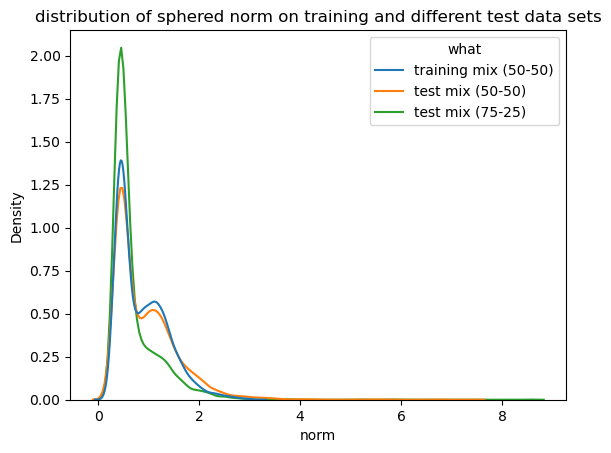

In [20]:
comparison_frame = pd.concat([
    pd.DataFrame({
        'norm': norm_xformed_train,
        'what': "training mix (50-50)",
    }),
    pd.DataFrame({
        'norm': norm_xformed_samepop,
        'what': "test mix (50-50)",
    }),
    pd.DataFrame({
        'norm': norm_xformed_shiftpop,
        'what': "test mix (75-25)",
    }),
])

sns.kdeplot(
    data=comparison_frame,
    x="norm",
    hue="what",
    common_norm=False,
)
plt.title("distribution of sphered norm on training and different test data sets")
plt.show()

### Difference of Distributions (PSI)

We can also measure the difference quantitatively using the Population Stability Index (or your preferred distribution divergence metric).

This PSI calculator uses decile binning. A common rule of thumb:

* PSI < 0.1: distributions are similar
* PSI between 0.1 and 0.25: distributions are somewhat different
* PSI > 0.25: distributions are very different

In [21]:
## create a PSI calculator to measure differences from reference norm distribution (transformed)
psiCalc = DistCalculator(norm_xformed_train)

{
    'psi 50-50 mix': psiCalc.PSI(norm_xformed_samepop),
    'psi 75-25 mix': psiCalc.PSI(norm_xformed_shiftpop)
}

{'psi 50-50 mix': 0.01968997708819725, 'psi 75-25 mix': 0.22287692999430095}

The PSI measurement flags the shifted distribution as somewhat different. As in the first task, the real space distributions show the same difference.

In [22]:
## create a PSI calculator to measure differences from reference norm distribution (original space)
psiCalc = DistCalculator(norm_train)

{
    'psi 50-50 mix': psiCalc.PSI(norm_samepop),
    'psi 75-25 mix': psiCalc.PSI(norm_shiftpop)
}

{'psi 50-50 mix': 0.0015433218214826992, 'psi 75-25 mix': 0.2418655261070141}